Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [4]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2242
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2242 files belonging to 9 classes.
Using 1794 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2242 files belonging to 9 classes.
Using 448 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print('Used for test')

Found 118 files belonging to 9 classes.
Used for test


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

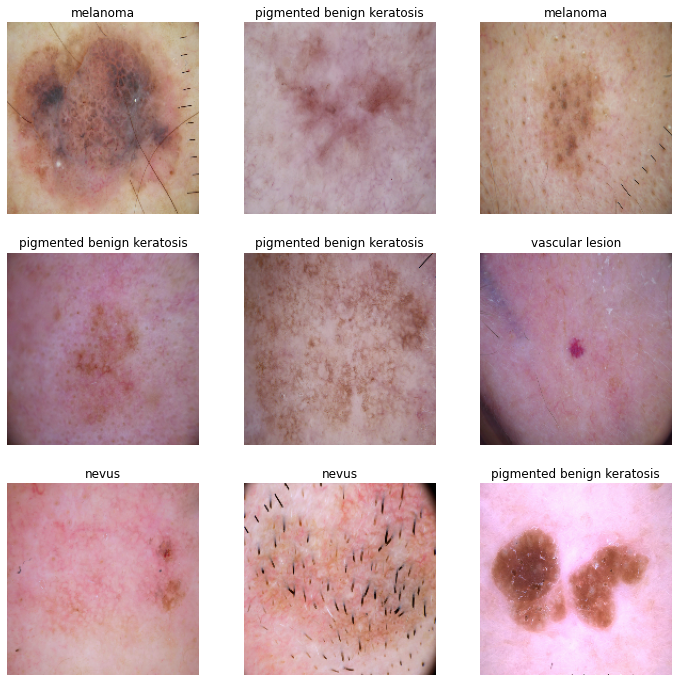

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

In [12]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

image_count_per_class = class_distribution_count(data_dir_train)
image_count_per_class

,Class,No. of Image
0,dermatofibroma,95
1,seborrheic keratosis,77
2,vascular lesion,142
3,squamous cell carcinoma,181
4,actinic keratosis,114
5,basal cell carcinoma,376
6,nevus,357
7,pigmented benign keratosis,462
8,melanoma,438


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [15]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Train the model

In [18]:
epochs = 20
batch_size=32

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, batch_size=batch_size
)

Epoch 1/20
57/57 [==============================] - 131s 733ms/step - loss: -80408.3750 - accuracy: 0.1711 - val_loss: -78396.0391 - val_accuracy: 0.1496
Epoch 2/20
57/57 [==============================] - 4s 71ms/step - loss: -856320.4375 - accuracy: 0.1722 - val_loss: -770318.3750 - val_accuracy: 0.1496
Epoch 3/20
57/57 [==============================] - 4s 70ms/step - loss: -3215328.5000 - accuracy: 0.1722 - val_loss: -3288400.0000 - val_accuracy: 0.1496
Epoch 4/20
57/57 [==============================] - 4s 71ms/step - loss: -7895561.5000 - accuracy: 0.1722 - val_loss: -7606540.5000 - val_accuracy: 0.1496
Epoch 5/20
57/57 [==============================] - 4s 71ms/step - loss: -15535832.0000 - accuracy: 0.1722 - val_loss: -15502227.0000 - val_accuracy: 0.1496
Epoch 6/20
57/57 [==============================] - 4s 71ms/step - loss: -27075080.0000 - accuracy: 0.1722 - val_loss: -29105780.0000 - val_accuracy: 0.1496
Epoch 7/20
57/57 [==============================] - 4s 70ms/step - lo

### Visualizing training results

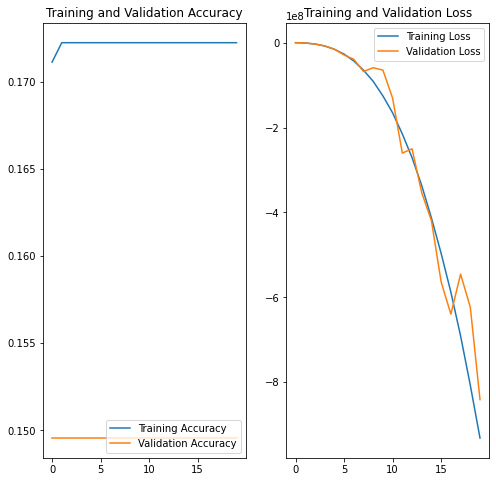

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [20]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model overfits and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 15ms/step - loss: -841189440.0000 - accuracy: 0.1496
Accuracy:  0.17224080860614777
Validation Accuracy:  0.1495535671710968
Loss:  -826060096.0
Validation Loss -841189440.0


In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']


In [22]:
train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

Found 890 images belonging to 9 classes.


In [23]:
valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 48 images belonging to 9 classes.


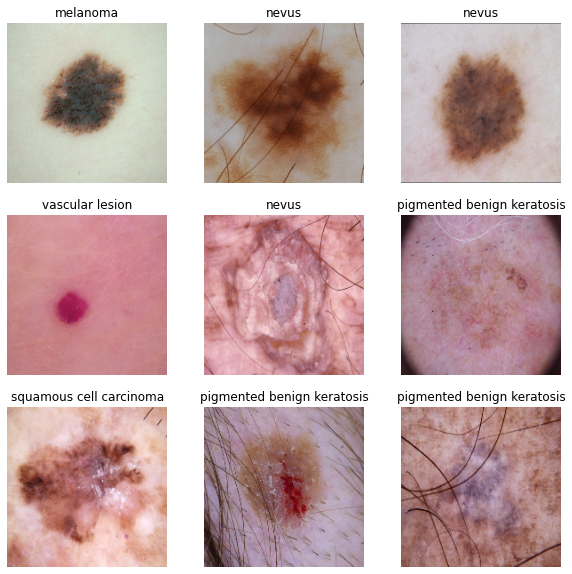

In [25]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))


### Compiling the model

In [27]:
## Your code goes here

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Training the model

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [28]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 52s 4s/step - loss: 147.7057 - accuracy: 0.4079 - val_loss: 1.6051 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 31s 2s/step - loss: 1.0063 - accuracy: 0.5067 - val_loss: 1.7090 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 31s 2s/step - loss: 0.8572 - accuracy: 0.6169 - val_loss: 1.7427 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - 32s 2s/step - loss: 0.7553 - accuracy: 0.6539 - val_loss: 1.5038 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 32s 2s/step - loss: 0.6903 - accuracy: 0.6910 - val_loss: 1.5140 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - 32s 2s/step - loss: 0.6946 - accuracy: 0.6787 - val_loss: 1.4541 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 7/20
14/14 [==============================] - 32s 2s/step - loss: 0.6939 -

In [30]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_13 (ModuleWr  (None, None, None, 32)   896       
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, None, None, 32)   9248      
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (None, None, None, 32)   0         
 apper)                                                          
                                                                 
 module_wrapper_16 (ModuleWr  (None, None, None, 32)   0         
 apper)                                                          
                                                                 
 module_wrapper_17 (ModuleWr  (None, None, None, 64)  

### Visualizing the results

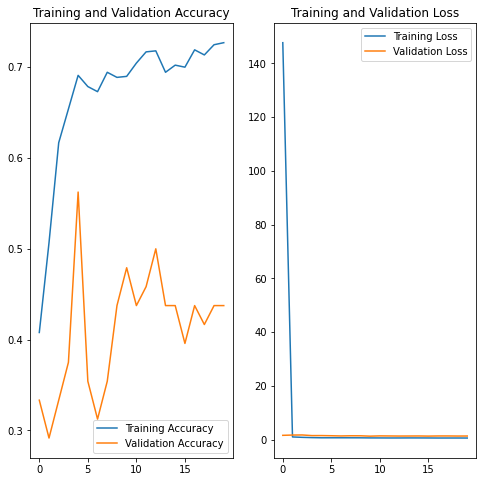

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

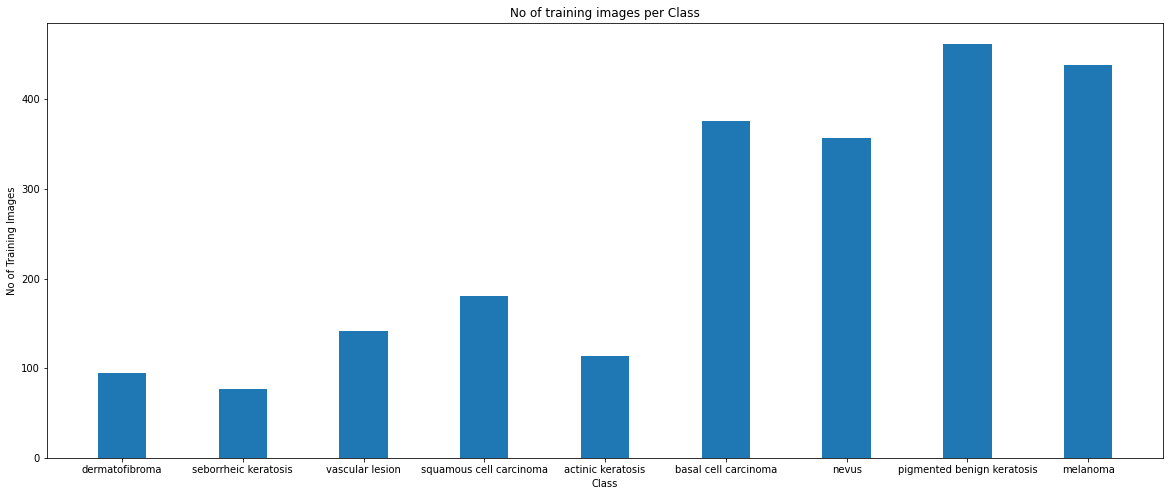

In [33]:
plt.figure(figsize=(20, 8))
plt.bar(image_count_per_class["Class"], image_count_per_class["No. of Image"], width = 0.4)
plt.xlabel("Class")
plt.ylabel("No of Training Images")
plt.title("No of training images per Class")
plt.show()

###  Write your findings here: 
#### - Which class has the least number of samples?
**Seborrheic Keratosis had the least number of samples**
### - Which classes dominate the data in terms proportionate number of samples?
**Pigmented benign Keratosis dominated the most**

In [34]:
#!pip install numpy --upgrade
!pip install Augmentor
#!pip uninstall image-augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [51]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F6663B5D0>: 100%|██████████| 500/500 [00:18<00:00, 26.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F66720C10>: 100%|██████████| 500/500 [00:20<00:00, 24.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F6663B650>: 100%|██████████| 500/500 [00:19<00:00, 26.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0F665F7BD0>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F0F66724F10>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0F674E8590>: 100%|██████████| 500/500 [00:22<00:00, 22.15 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0F66721C10>: 100%|██████████| 500/500 [00:44<00:00, 11.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0F666DA910>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]


Initialised with 142 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0F666D6B10>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [55]:
import glob

In [56]:
glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))

['/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_e89225db-4d63-4798-b9a2-b0d21c278d3d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_1378f158-d5af-4331-8fea-7fcba85df3b5.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_4f11e151-3851-4f23-bf6b-c8b57700164d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_e41d3a16-32e2-4683-bbbd-2a56cb637e0d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_f5764ff9-5430-498a-8411-428e71d6d152.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg

In [59]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_e89225db-4d63-4798-b9a2-b0d21c278d3d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_1378f158-d5af-4331-8fea-7fcba85df3b5.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_4f11e151-3851-4f23-bf6b-c8b57700164d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_e41d3a16-32e2-4683-bbbd-2a56cb637e0d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_f5764ff9-5430-498a-8411-428e71d6d152.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2
new_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,dermatofibroma
1,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,dermatofibroma
2,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,dermatofibroma
3,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,dermatofibroma
4,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,dermatofibroma
...,...,...
8995,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,melanoma
8996,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,melanoma
8997,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,melanoma
8998,/content/gdrive/MyDrive/Colab Notebooks/Skin_c...,melanoma


In [63]:
new_df['Label'].value_counts()

dermatofibroma                1000
seborrheic keratosis          1000
vascular lesion               1000
squamous cell carcinoma       1000
actinic keratosis             1000
basal cell carcinoma          1000
nevus                         1000
pigmented benign keratosis    1000
melanoma                      1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [64]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [65]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Skin_cancer_dataset/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11242 files belonging to 9 classes.
Using 8994 files for training.


#### **Todo:** Create a validation dataset

In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11242 files belonging to 9 classes.
Using 2248 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [67]:
## your code goes here
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [68]:
## your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [69]:
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
282/282 [==============================] - 61s 208ms/step - loss: 0.0000e+00 - accuracy: 0.1207 - val_loss: 0.0000e+00 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 2/50
282/282 [==============================] - 53s 186ms/step - loss: 0.0000e+00 - accuracy: 0.1207 - val_loss: 0.0000e+00 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 3/50
282/282 [==============================] - 52s 181ms/step - loss: 0.0000e+00 - accuracy: 0.1207 - val_loss: 0.0000e+00 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 4/50
281/282 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1208
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
282/282 [==============================] - 53s 184ms/step - loss: 0.0000e+00 - accuracy: 0.1207 - val_loss: 0.0000e+00 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 5/50
282/282 [==============================] - 52s 181ms/step - loss: 0.0000e+00 - accuracy: 0.1207 - val_loss: 0.0000e+00 - val_accuracy: 0.1290 - lr: 5.0000e-04
E

#### **Todo:**  Visualize the model results

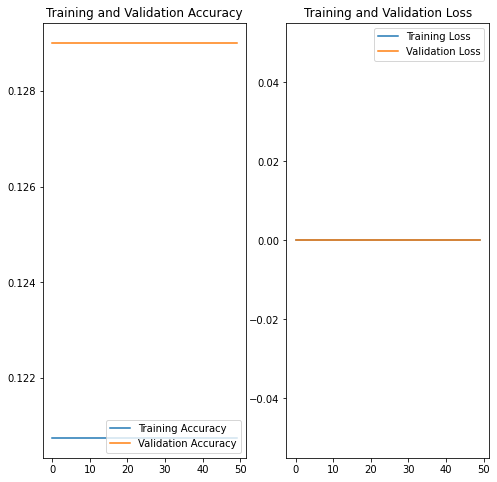

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced. But it reduced the Acurracy very low. Initially we tried without the ImageDataGenerator which created data to over fit at high ratio. Then we introduced dropout and ImageDataGenerator which reduced the over fit. At last we tried Batch Normalization and Augumentation which really helped in carry forward.